# Anemia Pipeline

In [29]:
# Imports
import os, json, joblib, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

RAW_PATH = "../data/raw/anemia_dataset.csv"
OUT_CLEAN = "../data/processed/anemia_cleaned.csv"
OUT_FUSION = "../data/processed/anemia_with_embeddings.csv"

FIG_DIR = "../reports/figures/anemia_before_cleaning/"
FIG_DIR_AFTER = "../reports/figures/anemia_after_cleaning/"
FIG_DIR_TRAIN = "../reports/figures/anemia_training/"
os.makedirs("../data/processed", exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(FIG_DIR_AFTER, exist_ok=True)
os.makedirs(FIG_DIR_TRAIN, exist_ok=True)

print("RAW_PATH:", RAW_PATH)

RAW_PATH: ../data/raw/anemia_dataset.csv


In [19]:
# Load data
df_raw = pd.read_csv(RAW_PATH)

# Drop junk unnamed columns
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains(r"^Unnamed", na=False)]

print("Shape:", df_raw.shape)
display(df_raw.head())

print("Columns:", df_raw.columns.tolist())
print(df_raw["Anaemic"].value_counts(dropna=False))

Shape: (104, 7)


,Number,Name,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,1,Jafor Alam,43.2555,30.8421,25.9025,6.3,Yes
1,2,khadiza,45.6033,28.1900,26.2067,13.5,No
2,3,Lalu,45.0107,28.9677,26.0215,11.7,No
3,4,Mira nath,44.5398,28.9899,26.4703,13.5,No
4,5,monoara,43.2870,30.6972,26.0158,12.4,No


Columns: ['Number', 'Name', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb', 'Anaemic']
Anaemic
No     78
Yes    26
Name: count, dtype: int64


# Visualizations before cleaning (raw data)

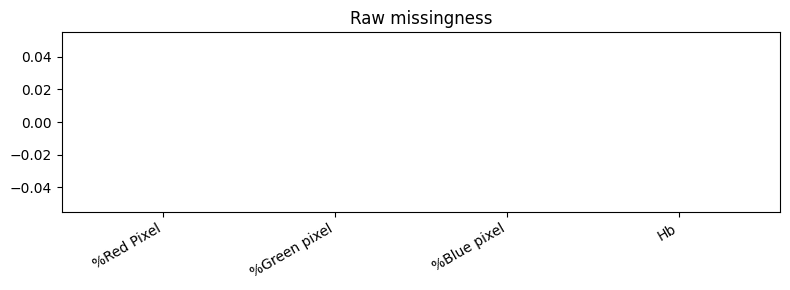

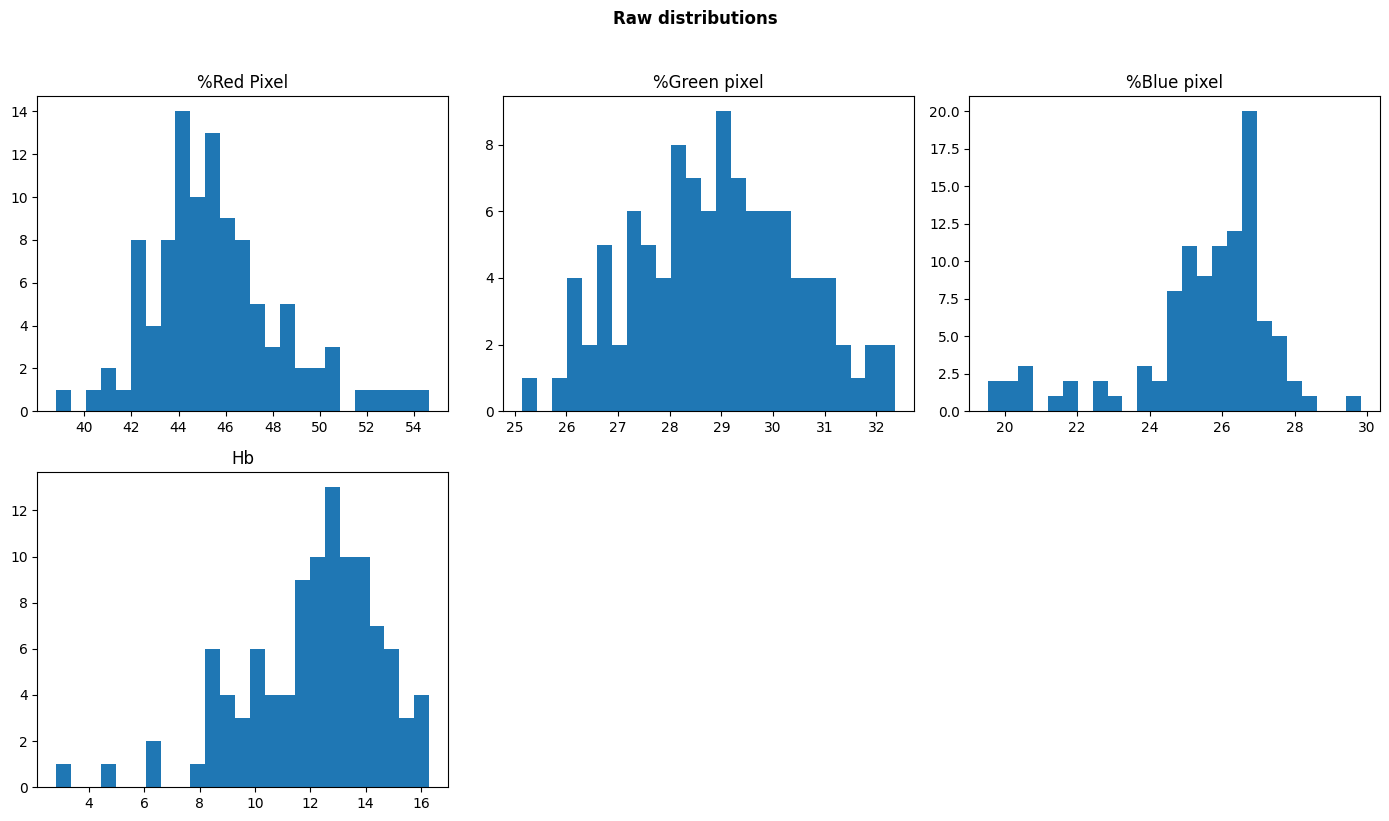

In [20]:
NUM_COLS_RAW = ["%Red Pixel", "%Green pixel", "%Blue pixel", "Hb"]

# Missingness
miss = df_raw[NUM_COLS_RAW].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,3))
plt.bar(miss.index, miss.values)
plt.xticks(rotation=30, ha="right")
plt.title("Raw missingness")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "raw_missingness.png"), dpi=150)
plt.show()

# Hist grid (3 cols)
cols = NUM_COLS_RAW
ncols = 3
nrows = math.ceil(len(cols)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.flatten()

for i, c in enumerate(cols):
    ax = axes[i]
    vals = pd.to_numeric(df_raw[c], errors="coerce").to_numpy()
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        ax.axis("off"); ax.set_title(c); continue
    ax.hist(vals, bins=25)
    ax.set_title(c)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Raw distributions", y=1.02, fontweight="bold")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "raw_hist_grid.png"), dpi=150, bbox_inches="tight")
plt.show()

# Cleaning and feature engineering

In [21]:
df = df_raw.copy()

# Rename columns to canonical names
df = df.rename(columns={
    "%Red Pixel": "red_pct",
    "%Green pixel": "green_pct",
    "%Blue pixel": "blue_pct",
    "Hb": "hb",
    "Anaemic": "anaemic"
})

# Coerce numeric
for c in ["red_pct","green_pct","blue_pct","hb"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Target: Yes/No - 1/0
df["anaemic"] = df["anaemic"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})
if df["anaemic"].isna().any():
    bad = df_raw.loc[df["anaemic"].isna(), "Anaemic"].unique()
    raise ValueError(f"Unexpected Anaemic values: {bad}")

# Drop rows missing essentials
before = len(df)
df = df.dropna(subset=["red_pct","green_pct","blue_pct","hb","anaemic"]).reset_index(drop=True)
print(f"Dropped {before-len(df)} rows with missing essentials")

# Feature engineering
eps = 1e-6
df["rgb_sum"] = df["red_pct"] + df["green_pct"] + df["blue_pct"]

# Normalize RGB to sum=1 
df["red_n"] = df["red_pct"] / (df["rgb_sum"] + eps)
df["green_n"] = df["green_pct"] / (df["rgb_sum"] + eps)
df["blue_n"] = df["blue_pct"] / (df["rgb_sum"] + eps)

df["rg_ratio"] = df["red_n"] / (df["green_n"] + eps)
df["pallor_index"] = (df["green_n"] + df["blue_n"]) / (df["red_n"] + eps)

PIX_FEATURES = ["red_n","green_n","blue_n","rg_ratio","pallor_index","rgb_sum"]
HB_FEATURES = ["hb"]

# Save cleaned
df.to_csv(OUT_CLEAN, index=False)
print(" Saved:", OUT_CLEAN)
print("Class balance:", df["anaemic"].mean())


Dropped 0 rows with missing essentials
 Saved: ../data/processed/anemia_cleaned.csv
Class balance: 0.25


# Visualizations after cleaning

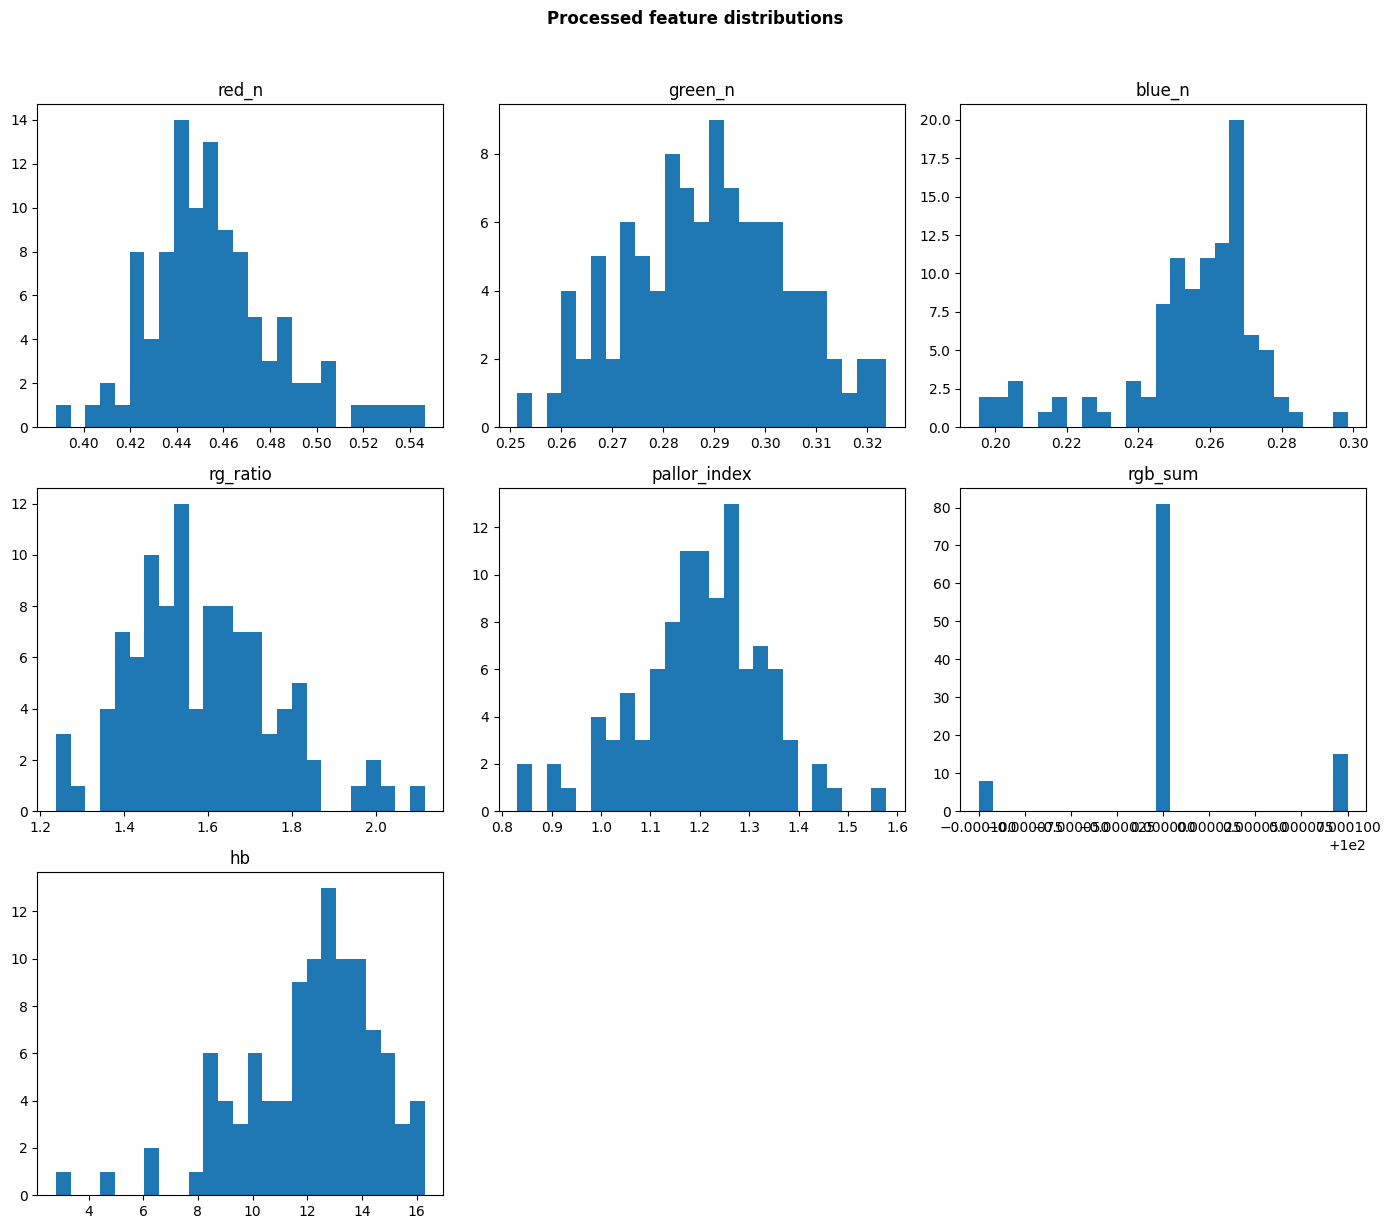

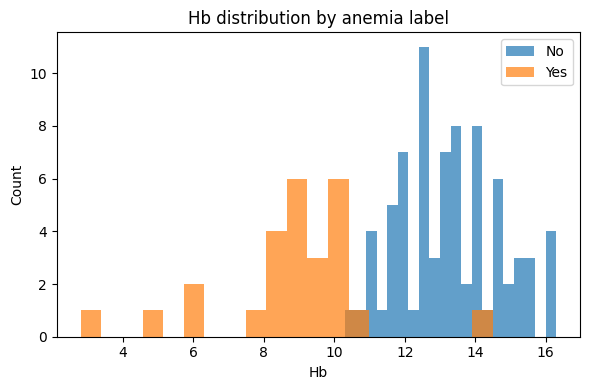

In [23]:
cols = PIX_FEATURES + HB_FEATURES
ncols = 3
nrows = math.ceil(len(cols)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.flatten()

for i, c in enumerate(cols):
    ax = axes[i]
    vals = pd.to_numeric(df[c], errors="coerce").to_numpy()
    vals = vals[np.isfinite(vals)]
    ax.hist(vals, bins=25)
    ax.set_title(c)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Processed feature distributions", y=1.02, fontweight="bold")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR_AFTER, "processed_hist_grid.png"), dpi=150, bbox_inches="tight")
plt.show()

# Hb vs anemia
plt.figure(figsize=(6,4))
plt.hist(df.loc[df["anaemic"]==0, "hb"], bins=20, alpha=0.7, label="No")
plt.hist(df.loc[df["anaemic"]==1, "hb"], bins=20, alpha=0.7, label="Yes")
plt.title("Hb distribution by anemia label")
plt.xlabel("Hb"); plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR_AFTER, "hb_by_label.png"), dpi=150)
plt.show()

# Model Building

In [24]:
def build_anemia_model(n_pix, n_hb, emb_dim=32, dropout=0.25, lr=1e-3):
    pix_in = Input(shape=(n_pix,), name="pixel_input")
    hb_in  = Input(shape=(n_hb,),  name="hb_input")

    # Pixel encoder - embedding
    x = Dense(64, activation="relu")(pix_in)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    emb = Dense(emb_dim, activation="relu", name="anemia_embedding")(x)

    # Hb branch
    h = Dense(8, activation="relu")(hb_in)
    h = BatchNormalization()(h)

    # Fusion head
    z = Concatenate()([emb, h])
    z = Dense(16, activation="relu")(z)
    z = Dropout(dropout)(z)
    out = Dense(1, activation="sigmoid", name="p_anemia")(z)

    model = Model([pix_in, hb_in], out, name="anemia_prob_model")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy")
    encoder = Model([pix_in, hb_in], emb, name="anemia_encoder")

    return model, encoder

In [25]:
# Training: 5-fold CV + out-of-fold calibration
X_pix = df[PIX_FEATURES].astype(float).values
X_hb  = df[HB_FEATURES].astype(float).values
y     = df["anaemic"].astype(int).values

sc_pix = StandardScaler()
sc_hb  = StandardScaler()

X_pix_s = sc_pix.fit_transform(X_pix)
X_hb_s  = sc_hb.fit_transform(X_hb)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_prob = np.zeros(len(y), dtype=float)
oof_emb  = np.zeros((len(y), 32), dtype=float)

fold_metrics = []

for fold, (tr, te) in enumerate(skf.split(X_pix_s, y), start=1):
    model, encoder = build_anemia_model(X_pix_s.shape[1], X_hb_s.shape[1], emb_dim=32)

    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ReduceLROnPlateau(patience=8, factor=0.5)
    ]

    model.fit(
        [X_pix_s[tr], X_hb_s[tr]], y[tr],
        validation_split=0.2,
        epochs=300,
        batch_size=16,
        callbacks=callbacks,
        verbose=0
    )

    prob = model.predict([X_pix_s[te], X_hb_s[te]], verbose=0).reshape(-1)
    emb  = encoder.predict([X_pix_s[te], X_hb_s[te]], verbose=0)

    oof_prob[te] = prob
    oof_emb[te]  = emb

    roc = roc_auc_score(y[te], prob)
    pr  = average_precision_score(y[te], prob)
    fold_metrics.append({"fold": fold, "roc_auc": float(roc), "pr_auc": float(pr)})
    print(f"Fold {fold}: ROC-AUC={roc:.3f} PR-AUC={pr:.3f}")

print("Mean ROC-AUC:", np.mean([m["roc_auc"] for m in fold_metrics]))
print("Mean PR-AUC :", np.mean([m["pr_auc"] for m in fold_metrics]))

Fold 1: ROC-AUC=1.000 PR-AUC=1.000
Fold 2: ROC-AUC=0.938 PR-AUC=0.871
Fold 3: ROC-AUC=1.000 PR-AUC=1.000
Fold 4: ROC-AUC=0.812 PR-AUC=0.850
Fold 5: ROC-AUC=1.000 PR-AUC=1.000
Mean ROC-AUC: 0.95
Mean PR-AUC : 0.9442222222222224


In [27]:
# Calibrate probabilities (Platt scaling)
calibrator = LogisticRegression(solver="lbfgs")
calibrator.fit(oof_prob.reshape(-1,1), y)

oof_prob_cal = calibrator.predict_proba(oof_prob.reshape(-1,1))[:,1]
print("OOF ROC-AUC calibrated:", roc_auc_score(y, oof_prob_cal))
print("OOF PR-AUC calibrated :", average_precision_score(y, oof_prob_cal))

OOF ROC-AUC calibrated: 0.9541420118343196
OOF PR-AUC calibrated : 0.9437202693343045


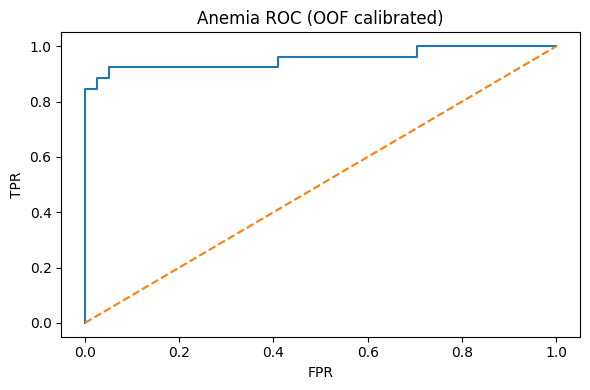

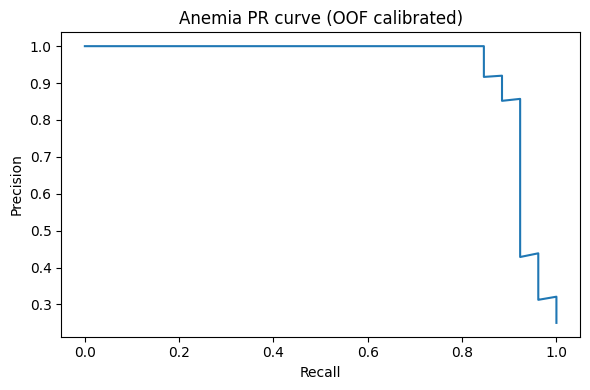

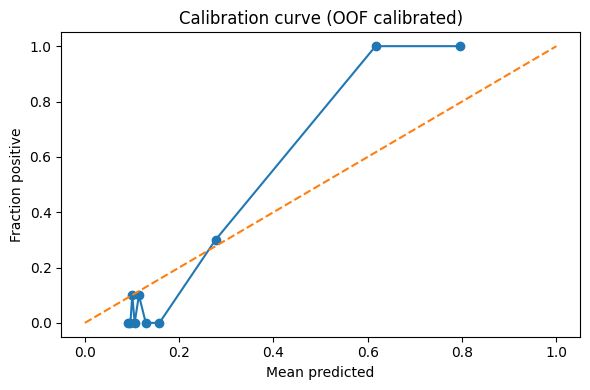

In [30]:
# Evaluation plots (ROC, PR, calibration)
# ROC curve
fpr, tpr, _ = roc_curve(y, oof_prob_cal)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"--")
plt.title("Anemia ROC (OOF calibrated)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR_TRAIN, "roc_oof_calibrated.png"), dpi=150)
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y, oof_prob_cal)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.title("Anemia PR curve (OOF calibrated)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR_TRAIN, "pr_oof_calibrated.png"), dpi=150)
plt.show()

# Calibration curve
frac_pos, mean_pred = calibration_curve(y, oof_prob_cal, n_bins=10, strategy="quantile")
plt.figure(figsize=(6,4))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1],[0,1],"--")
plt.title("Calibration curve (OOF calibrated)")
plt.xlabel("Mean predicted"); plt.ylabel("Fraction positive")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR_TRAIN, "calibration_oof.png"), dpi=150)
plt.show()

In [31]:
# Train final model on all data, save artifacts, and export embeddings
final_model, final_encoder = build_anemia_model(X_pix_s.shape[1], X_hb_s.shape[1], emb_dim=32)
final_model.fit(
    [X_pix_s, X_hb_s], y,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True),
               ReduceLROnPlateau(patience=8, factor=0.5)],
    verbose=0
)

p_raw = final_model.predict([X_pix_s, X_hb_s], verbose=0).reshape(-1)
p_cal = calibrator.predict_proba(p_raw.reshape(-1,1))[:,1]
emb_all = final_encoder.predict([X_pix_s, X_hb_s], verbose=0)

# Versioned artifact dir
version = datetime.now().strftime("%Y%m%d_%H%M%S")
ART_DIR = f"../models_artifacts/anemia/{version}"
os.makedirs(ART_DIR, exist_ok=True)

final_model.save(os.path.join(ART_DIR, "model.h5"))
final_encoder.save(os.path.join(ART_DIR, "encoder.h5"))
joblib.dump(sc_pix, os.path.join(ART_DIR, "scaler_pixels.pkl"))
joblib.dump(sc_hb, os.path.join(ART_DIR, "scaler_hb.pkl"))
joblib.dump(calibrator, os.path.join(ART_DIR, "calibrator.pkl"))

meta = {
    "version": version,
    "pixel_features": PIX_FEATURES,
    "hb_features": HB_FEATURES,
    "embedding_dim": 32,
    "cv_metrics": fold_metrics,
    "oof_roc_auc_cal": float(roc_auc_score(y, oof_prob_cal)),
    "oof_pr_auc_cal": float(average_precision_score(y, oof_prob_cal)),
}
with open(os.path.join(ART_DIR, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print(" Saved artifacts to:", ART_DIR)

# Export fusion-ready dataset
emb_cols = [f"anemia_emb_{i}" for i in range(32)]
df_out = df.copy()
df_out["p_anemia_raw"] = p_raw
df_out["p_anemia"] = p_cal
df_out[emb_cols] = emb_all

df_out.to_csv(OUT_FUSION, index=False)
print(" Saved:", OUT_FUSION)

 Saved artifacts to: ../models_artifacts/anemia/20260220_012155
 Saved: ../data/processed/anemia_with_embeddings.csv
